In [1]:
%matplotlib inline

In [2]:
import numpy as np
np.random.seed(123)  # for reproducibility

## Load data

In [3]:
import os
import cv2
import csv
from matplotlib import pyplot as plt

In [4]:
train_data_path = 'D:\\text_recognition_data\\COCO-Text-words-trainval\\train_words'
train_labels_path = "D:\\text_recognition_data\\COCO-Text-words-trainval\\train_words_gt_upgrade.txt"
# train_data = map(lambda x: train_data_path+"\\"+x, os.listdir(train_data_path))
# train_data = list(map(cv2.imread, train_data))
with(open(train_labels_path, 'r', encoding='UTF-8')) as train_labels_file:
    reader = csv.reader(train_labels_file, delimiter='~')
    reader = [a for index, a in enumerate(reader) if index < 100]
    train_labels = dict(reader)

In [5]:
X = []
y = []
for filename, value in train_labels.items():
    X.append(cv2.imread("{}\\{}.jpg".format(train_data_path, filename)))
    y.append(value)

In [6]:
X[1].shape

(23, 120, 3)

In [7]:
import operator
find_max_shape = list(map(lambda x: x.shape, X))
height_max = max(find_max_shape, key=operator.itemgetter(0))[0]
width_max = max(find_max_shape, key=operator.itemgetter(1))[1]

In [8]:
color = [0, 0, 0]
for index, image in enumerate(X):
    old_height, old_width = image.shape[:2] 
    new_im = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    new_im = cv2.copyMakeBorder(new_im, 0, height_max - old_height, 0, width_max - old_width, cv2.BORDER_CONSTANT, value=color)
    X[index] = new_im

Chiquita


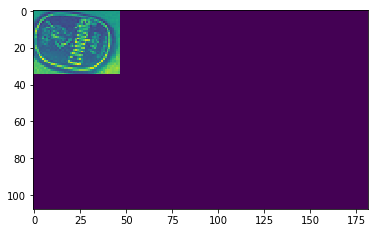

In [9]:
print(y[0])
plt.imshow(X[0])

In [10]:
from keras.layers.core import Layer

class CustomZeroPadding2D(Layer):
    '''Zero-padding layer for 2D input (e.g. picture).
    # Input shape
        4D tensor with shape:
        (samples, depth, first_axis_to_pad, second_axis_to_pad)
    # Output shape
        4D tensor with shape:
        (samples, depth, first_padded_axis, second_padded_axis)
    # Arguments
        padding: tuple of int (length 4)
            How many zeros to add at the beginning and end of
            the padding dimensions (axis 3 and 4).
    '''
    input_ndim = 4

    def __init__(self, padding=(1, 1), dim_ordering='th', **kwargs):
        super(CustomZeroPadding2D, self).__init__(**kwargs)
        self.padding = tuple(padding)
        assert dim_ordering in {'tf', 'th'}, 'dim_ordering must be in {tf, th}'
        self.dim_ordering = dim_ordering

    @property
    def output_shape(self):
        input_shape = self.input_shape
        if self.dim_ordering == 'th':
            width = input_shape[2] + self.padding[0] + self.padding[1] if input_shape[2] is not None else None
            height = input_shape[3] + self.padding[2] + self.padding[3] if input_shape[3] is not None else None
            return (input_shape[0],
                    input_shape[1],
                    width,
                    height)
        elif self.dim_ordering == 'tf':
            width = input_shape[1] + self.padding[0] + self.padding[1] if input_shape[2] is not None else None
            height = input_shape[2] + self.padding[2] + self.padding[3] if input_shape[3] is not None else None
            return (input_shape[0],
                    width,
                    height,
                    input_shape[3])
        else:
            raise Exception('Invalid dim_ordering: ' + self.dim_ordering)

Using Theano backend.


In [11]:
from keras.models import Sequential

from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

from keras.utils import np_utils

from keras.optimizers import SGD

from keras import backend as K
K.set_image_dim_ordering('th')

In [12]:
model = Sequential()

#1 layer
model.add(Convolution2D(64, (5, 5), input_shape=(1, 108, 182), activation='relu', padding='same',kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#2 layer
model.add(Convolution2D(128, (5, 5), padding='same',activation='relu',kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#3 layer
model.add(Convolution2D(256, (3,3),
        padding='same',activation='relu',kernel_initializer='glorot_uniform'))

# 3.5 layer - border_mode = 'same' preserves dimensionality
model.add(Convolution2D(512, (3,3),
        padding='same',activation='relu',kernel_initializer='glorot_uniform'))

# Need to zero pad one column on the right hand size of the output so pooling works 
model.add(CustomZeroPadding2D(padding=(0,0,0,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth layer - border_mode = 'same' preserves dimensionality
model.add(Convolution2D(512, (3,3),
        padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    
# First Dense layer
model.add(Flatten())
model.add(Dense(4096,activation='relu',kernel_initializer='glorot_uniform'))
model.add(Dropout(0.5))

# Second Dense layer
model.add(Dense(4096,activation='relu',kernel_initializer='glorot_uniform'))
model.add(Dropout(0.5))

model.add(Dense(23*37, activation='sigmoid'))

In [13]:
X = np.array(X)
X = X.reshape(X.shape[0], 1, height_max, width_max)
y = np.array(y)
y.shape

(100,)

In [14]:
output_str = '0123456789abcdefghijklmnopqrstuvwxyz '
output = [x for x in output_str]

In [15]:
y_wtf = np.zeros((y.shape[0], 23, 37))
for k, word in enumerate(y):
    word_ = word.lower()
    word_matrix = np.zeros((23, 37))
    ind_row = 0
    for char in word_:
        if char not in output:
            ind_row+=1
        else:
            word_matrix[ind_row][output.index(char)] = 1
        ind_row += 1
    y_wtf[k] = word_matrix

In [16]:
y_wtf = y_wtf.reshape(y_wtf.shape[0], 23*37)

In [17]:
print(y[0])
y_wtf[0]

Chiquita


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0

In [18]:
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [19]:
model.fit(X, y_wtf, batch_size=16, epochs=5, verbose=1)

Epoch 1/5
100/100 [==============================] - 108s 1s/step - loss: 0.6221
Epoch 2/5
100/100 [==============================] - 121s 1s/step - loss: 0.1520
Epoch 3/5
100/100 [==============================] - 134s 1s/step - loss: 0.0615
Epoch 4/5
100/100 [==============================] - 153s 2s/step - loss: 0.0495
Epoch 5/5
100/100 [==============================] - 135s 1s/step - loss: 0.0430


In [20]:
X_toshow = X.reshape(X.shape[0], height_max, width_max)

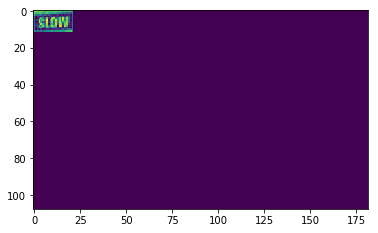

In [21]:
plt.imshow(X_toshow[4])

In [22]:
answer = model.predict(np.array([X[4]]), verbose=0)

In [23]:
answer_r = answer.reshape(23, 37)
chars = []
for row in answer_r:
    chars.append(output[np.argmax(row)])

In [24]:
''.join(chars)

'aoatitgreh30rgt6njabsyb'